In [61]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
import rpy2.robjects as robjects

from rpy2.robjects import pandas2ri
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import lil_matrix
from location import get_lat_long

data_dir = os.path.join('data','brvehins/')

## Load raw data and secrets

The file `data/brvehins_raw.parquet` was generated by loading data from the R package `CASdatasets` and then saving it as a parquet file. Since this may require R to be installed, we omit it from this repository to avoid R as a dependency.

In [62]:
raw_path = os.path.join(data_dir,'brvehins_raw.parquet')
df = pd.read_parquet(raw_path)

secrets_path = '.secrets.json'
with open(secrets_path) as f:
    secrets = json.load(f)

In [ ]:
df

,VehYear,VehModel,VehGroup,City,CityCode,Area,State,StateAb,ExposTotal,PremTotal,ClaimNbRob,ClaimNbColl,ClaimNbFire,ClaimNbOther,ClaimAmountRob,ClaimAmountColl,ClaimAmountFire,ClaimAmountOther
0,2011,Ford - Fiesta 1.0 8v Flex 5p,Ford Fiesta 1.0,Ipeuna,352110.0,Ribeirao Preto e Demais Mun. de Campinas,Sao Paulo,SP,0.51,383.40,0,0,0,0,0,0.0,0,0
1,2003,Gm - Chevrolet - S10 P-up 2.8/sert. 2.8 4x4 Tb...,Gm Chevrolet S-10,Monte Alto,353130.0,Ribeirao Preto e Demais Mun. de Campinas,Sao Paulo,SP,0.50,818.95,0,0,0,0,0,0.0,0,0
2,1998,Gm - Chevrolet - Corsa Wagon Gls 1.6 16v Mpfi 4p,Gm Chevrolet Corsa Acima De 1.0,Ribeirao Das Neves (ver Cep Por Logradouros),NaN,Met.BH-Centro Oeste-Zona Mata-C. Vertentes,Minas Gerais,MG,0.17,175.05,0,0,0,0,0,0.0,0,0
3,1982,Mercedes-benz - L-1113 2p (diesel),Mercedes-benz Caminhoes - Outros,Imbuia,420740.0,Blumenau e demais regioes,Santa Catarina,SC,0.20,44.26,0,0,0,0,0,0.0,0,0
4,2009,Honda - Cg 125 Fan / Fan Ks,Honda Motos Ate 450cc,Sao Jose,421660.0,Met. Florianopolis e Sul,Santa Catarina,SC,2.18,779.90,0,0,0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667747,2009,Chrysler - 300 C 3.5 V6 249cv,Chrysler - Todos,Piracicaba,353870.0,Ribeirao Preto e Demais Mun. de Campinas,Sao Paulo,SP,0.50,1664.54,0,0,0,0,0,0.0,0,0
2667748,2004,Gm - Chevrolet - Celta 1.0/super/n.piq.1.0 Mpf...,Gm Chevrolet Celta 1.0,Paraiba,NaN,Paraiba,Paraiba,PB,0.21,184.11,0,0,0,0,0,0.0,0,0
2667749,2000,Fiat - Palio Weekend Stile 1.6 Mpi 16v 4p,Fiat Palio Weekend,Juiz De Fora,NaN,Met.BH-Centro Oeste-Zona Mata-C. Vertentes,Minas Gerais,MG,2.75,2421.89,0,0,0,0,0,0.0,0,0
2667750,2010,Gm - Chevrolet - Vectra Elegan. 2.0 Mpfi 8v Fl...,Gm Chevrolet Vectra,Pedro Leopoldo,NaN,Met.BH-Centro Oeste-Zona Mata-C. Vertentes,Minas Gerais,MG,1.01,1667.80,0,0,0,0,0,0.0,0,0


## Data summary

In [ ]:
df.columns

Index(['VehYear', 'VehModel', 'VehGroup', 'City', 'CityCode', 'Area', 'State',
       'StateAb', 'ExposTotal', 'PremTotal', 'ClaimNbRob', 'ClaimNbColl',
       'ClaimNbFire', 'ClaimNbOther', 'ClaimAmountRob', 'ClaimAmountColl',
       'ClaimAmountFire', 'ClaimAmountOther'],
      dtype='object')

In [ ]:
df.head(3)

,VehYear,VehModel,VehGroup,City,CityCode,Area,State,StateAb,ExposTotal,PremTotal,ClaimNbRob,ClaimNbColl,ClaimNbFire,ClaimNbOther,ClaimAmountRob,ClaimAmountColl,ClaimAmountFire,ClaimAmountOther
0,2011,Ford - Fiesta 1.0 8v Flex 5p,Ford Fiesta 1.0,Ipeuna,352110.0,Ribeirao Preto e Demais Mun. de Campinas,Sao Paulo,SP,0.51,383.40,0,0,0,0,0,0.0,0,0
1,2003,Gm - Chevrolet - S10 P-up 2.8/sert. 2.8 4x4 Tb...,Gm Chevrolet S-10,Monte Alto,353130.0,Ribeirao Preto e Demais Mun. de Campinas,Sao Paulo,SP,0.50,818.95,0,0,0,0,0,0.0,0,0
2,1998,Gm - Chevrolet - Corsa Wagon Gls 1.6 16v Mpfi 4p,Gm Chevrolet Corsa Acima De 1.0,Ribeirao Das Neves (ver Cep Por Logradouros),NaN,Met.BH-Centro Oeste-Zona Mata-C. Vertentes,Minas Gerais,MG,0.17,175.05,0,0,0,0,0,0.0,0,0


In [ ]:
df.isnull().sum(axis=0).sort_values(ascending=False).head(8)

CityCode           993672
VehGroup           141384
VehModel           141384
City                 2020
VehYear                 0
ClaimNbColl             0
ClaimAmountFire         0
ClaimAmountColl         0
dtype: int64

In [ ]:
df.ExposTotal.min(), df.ExposTotal.max()

(0.0, 2963.26)

In [ ]:
df['PremTotal'].max(), df['ClaimAmountRob'].max()

(4317833.7, 1689159)

### Unique value counts for geo units

In [ ]:
for col in ['Area', 'City', 'CityCode', 'State', 'StateAb']:
    print(f"# of unique values for column {col}: {df[col].nunique()}")

# of unique values for column Area: 40
# of unique values for column City: 3417
# of unique values for column CityCode: 1627
# of unique values for column State: 27
# of unique values for column StateAb: 27


## Policies per state

In [ ]:
print(df['State'].value_counts().sort_values(ascending=False).head(5))
print(df['State'].value_counts().sort_values(ascending=False).tail(5))

State
Sao Paulo            860584
Minas Gerais         346948
Rio Grande do Sul    339644
Parana               289200
Santa Catarina       251648
Name: count, dtype: int64
State
Piaui       5112
Acre        2632
Amapa       2184
Roraima     2040
Rondonia    1928
Name: count, dtype: int64


### Value counts for number of claims, per claim category

In [ ]:
n_claim_cols = [col for col in df.columns if 'ClaimNb' in col]

for c in n_claim_cols:
    print(df[c].value_counts().sort_values(ascending=False).head(6))

ClaimNbRob
0    2632696
1      27840
2       4284
3       1132
4        608
5        316
Name: count, dtype: int64
ClaimNbColl
0    2441388
1     162388
2      32108
3      11732
4       5796
5       3252
Name: count, dtype: int64
ClaimNbFire
0    2666332
1       1368
2         44
3          4
6          4
Name: count, dtype: int64
ClaimNbOther
0    2491556
1      87884
2      30616
3      16528
4       9764
5       6388
Name: count, dtype: int64


### Unique value counts for vehicle descriptions

In [ ]:
len(df['VehModel'].unique()), len(df['VehGroup'].unique())

(3891, 412)

### Histogram of nonzero claim amounts (in Brazilian Reals)

Note that the USD-BRL exchange rate used to be 1 to 2 around 2011. Current values are ~1 to 5.

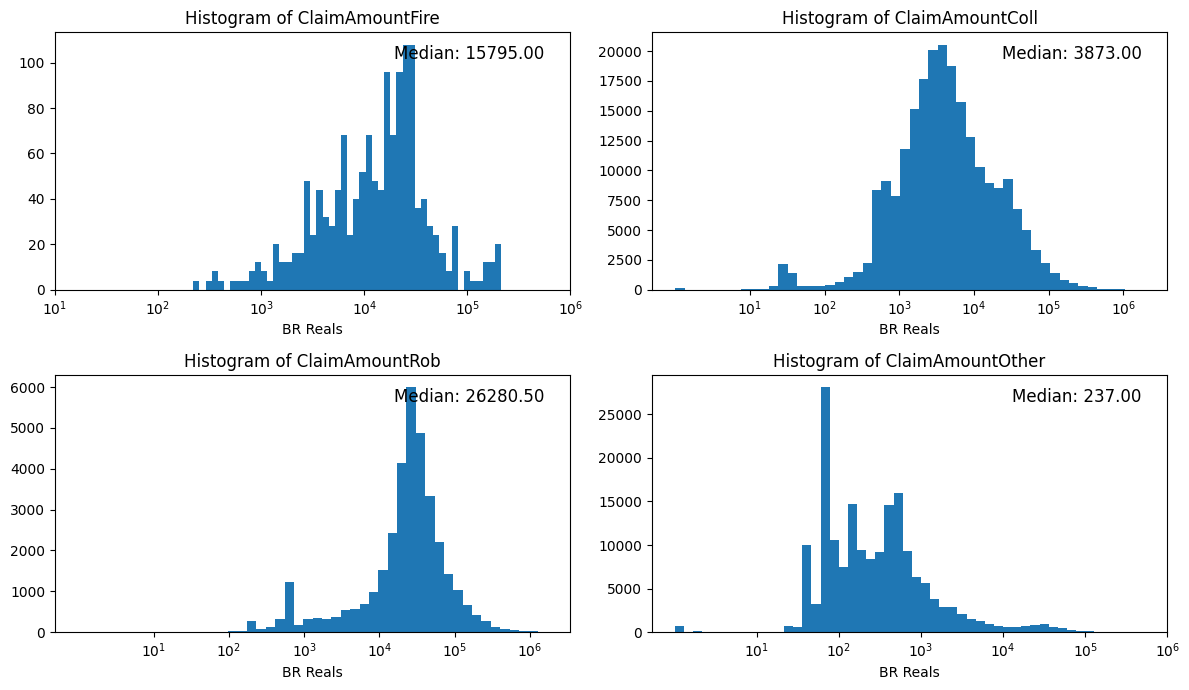

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(12,7))

axes = axes.flatten()

claim_cols = ['ClaimAmountFire', 'ClaimAmountColl', 'ClaimAmountRob', 'ClaimAmountOther']

for i, col in enumerate(claim_cols):
    nonzero_rows = df.query(f'{col} > 0')[col]

    # Histogram in log 10 values
    axes[i].hist(np.log10(nonzero_rows), bins=50)
    axes[i].set_title(f'Histogram of {col}')
    # Add median in upper right
    median = nonzero_rows.median()
    axes[i].text(0.95, 0.95, f'Median: {median:.2f}', transform=axes[i].transAxes, fontsize=12, horizontalalignment='right', verticalalignment='top')

    # Change tickmarkers to reflect log10 USD prices
    xvals = range(1,7)
    axes[i].set_xticks(xvals)
    axes[i].set_xticklabels([f'$10^{{{x}}}$' for x in xvals])
    axes[i].set_xlabel('BR Reals')

plt.tight_layout()

### Ratio of Premiums to Exposure

In [ ]:
df['PremToExpos'] = df['PremTotal'] / df['ExposTotal']

# Get quantiles of PremToExpos
quantiles = df['PremToExpos'].quantile([0.25, 0.5, 0.75])
print(quantiles)

0.25     640.480000
0.50     957.361818
0.75    1538.240185
Name: PremToExpos, dtype: float64


### Ratio of paid claims to premiums

Text(0.5, 0, 'Claim amount / premium amount)')

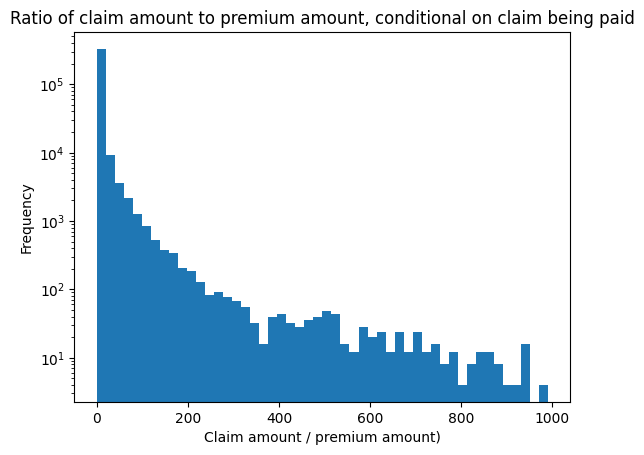

In [ ]:
df['ClaimAmountCombined'] = df['ClaimAmountFire'] + df['ClaimAmountColl'] + df['ClaimAmountRob'] + df['ClaimAmountOther']
df['ClaimToPrem'] = df['ClaimAmountCombined'] / df['PremTotal']

# For rows in which a claim was paid, we want the histogram of the ratio
# of the claim amount to the premium amount
was_paid = df.query('ClaimAmountCombined > 0 and PremTotal > 0 and ClaimToPrem < 1000')['ClaimToPrem']

# Make hist with log bins
plt.hist(was_paid, bins=50, log=True);
plt.title("Ratio of claim amount to premium amount, conditional on claim being paid")
plt.ylabel("Frequency")
plt.xlabel("Claim amount / premium amount)")


## Log-exposure histogram

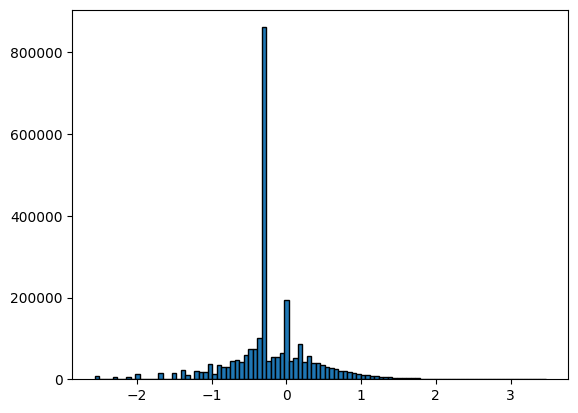

In [ ]:
plt.hist(np.log10(df.query('ExposTotal > 0')['ExposTotal']), bins=100,edgecolor='k');

# Data cleaning

### Simplifying vehicle model taxonomy

In [ ]:
# Replace null / NaN values in VehGroup and VehModel with "Unknown"
df['VehGroup'].fillna('Unknown', inplace=True)
df['VehModel'].fillna('Unknown', inplace=True)


In [ ]:
# Load the category mapping file
# and apply it to the vehicle group
category_filepath = os.path.join(data_dir,'veh_categories.json')

with open(category_filepath) as f:
    category_map = json.load(f)

df['VehCategory'] = df['VehGroup'].map(category_map)

# Map all null / nan to unknown
df['VehCategory'].fillna('Unknown', inplace=True)
df['VehCategory'].unique()

array(['Hatchback', 'Pickup', 'Truck', 'Motorcycle', 'Minivan', 'Sedan',
       'Unknown', 'Wagon', 'SUV', 'Others', 'Van', 'Sports Car',
       'Compact', 'Bus', 'Coupe'], dtype=object)

In [ ]:
# Extract the brand (i.e. VW, Ford) from the model field
df['VehBrand'] = df['VehModel'].str.rsplit(' - ', n=1, expand=True)[0]

# Replace 'Vw - Volkswagen' with 'Volkswagen'
df['VehBrand'] = df['VehBrand'].str.replace('Vw', 'Volkswagen')
df['VehBrand'].unique()

array(['Ford', 'Gm - Chevrolet', 'Mercedes-benz', 'Honda', 'Peugeot',
       'Volkswagen', 'Toyota', 'Unknown', 'Fiat',
       'Volkswagen - Volkswagen', 'Citroen', 'Renault', 'Suzuki', 'Dodge',
       'Scania', 'Chevrolet', 'Audi', 'Mitsubishi', 'Land Rover',
       'Outros', 'Subaru', 'Hyundai', 'Volvo', 'Kia Motors', 'Yamaha',
       'Iveco', 'Harley-davidson', 'Agrale', 'Bmw', 'Alfa Romeo', 'Seat',
       'Gmc', 'Saab-scania', 'Husqvarna', 'Ssangyong', 'Kawasaki',
       'Nissan', 'Marcopolo', 'Triumph', 'Sundown', 'Chrysler', 'Dafra',
       'Troller', 'Asia Motors', 'Lada', 'Navistar', 'Kasinski',
       'Mahindra', 'Engesa', 'Buell', 'Daewoo', 'Jeep', 'Chana', 'Jaguar',
       'Porsche', 'Hafei', 'Effa', 'Gurgel', 'Am Gen', 'Brm', 'Fym',
       'Amazonas', 'Dayun', 'Jpx', 'Shineray', 'Neobus', 'Traxx',
       'Ferrari', 'Mazda', 'Maserati', 'Brp', 'Daihatsu', 'Cagiva',
       'Haobao', 'Acura', 'Piaggio', 'Lexus', 'Miza', 'Envemo', 'Matra',
       'Garinni', 'Bimota', 'Ktm', 'Pu

### Geocoding city-state strings

In [ ]:
# All of the missing city/city codes are for the "Oeste Catarinense" region
# so we replace the NaN cities for rows with Santa Catarina state
# with "Oeste Catarinense"
is_nan_city = df['City'].isnull()
is_sc_state = df['State'] == 'Santa Catarina'
df['City'][is_nan_city & is_sc_state] = "Oeste Catarinense"
df['city-state'] = df['City'] + ', ' + df['State'] + ', Brazil'


/var/folders/6x/kygxkvrj2gg1s98_1d7ndy5m0000gn/T/ipykernel_11530/2763930448.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['City'][is_nan_city & is_sc_state] = "Oeste Catarinense"


In [ ]:
# We send requests to the Google Maps Geocoding API with strings
# like ""São Paulo, SP, Brazil" and get back the lat-longs
LOAD_FROM_DISK = True
city_coord_path = os.path.join(data_dir, 'br_city_lat_long.parquet')

if LOAD_FROM_DISK:
    city_df = pd.read_parquet(city_coord_path)
else:
    print("Loading lat-longs from Google Maps API")
    google_maps_api_key = secrets['google_maps_api_key']

    city_df = df[['city-state']].drop_duplicates()

    # Apply the function to each row in the DataFrame
    city_df["lat-long"] = city_df["city-state"].apply(lambda x: get_lat_long(x, google_maps_api_key))

    city_df['lat'] = city_df['lat-long'].apply(lambda x: x[0])
    city_df['long'] = city_df['lat-long'].apply(lambda x: x[1])

    # Manually set the lat-long for the cities that the API couldn't find
    manual_lat_longs = {
        "Querencia Do Norte, Parana, Brazil": (-23.083889, -53.483333),
    }

    for city_state, lat_long in manual_lat_longs.items():
        city_df.loc[city_df['city-state'] == city_state, ['lat', 'long']] = lat_long

    # Replace any of the NaN city states with the Oeste Catarinense lat-long
    city_df.lat.fillna(-26.5, inplace=True)
    city_df.long.fillna(-52.5, inplace=True)
    city_df['city-state'].fillna("Oeste Catarinense, Santa Catarina, Brazil", inplace=True)

    city_df.sort_values('city-state', inplace=True)
    city_df['city_idx'] = np.arange(len(city_df))
    city_df.set_index('city_idx', inplace=True, drop=False)

    assert not city_df.lat.isnull().any()
    city_df.to_parquet(city_coord_path)

df = df.merge(city_df[['city-state', 'city_idx']], left_on='city-state', right_on='city-state', how='left')

In [ ]:
city_df

,city-state,lat-long,lat,long,city_idx
city_idx,,,,,
0,"Abadia Dos Dourados, Minas Gerais, Brazil","[-18.4868648, -47.4030649]",-18.486865,-47.403065,0
1,"Abadiania, Distrito Federal, Brazil","[-16.1973129, -48.7060927]",-16.197313,-48.706093,1
2,"Abadiania, Goias, Brazil","[-16.1973129, -48.7060927]",-16.197313,-48.706093,2
3,"Abaete, Minas Gerais, Brazil","[-19.1575065, -45.4447686]",-19.157507,-45.444769,3
4,"Abaiara, Ceara, Brazil","[-7.3468979, -39.0323468]",-7.346898,-39.032347,4
...,...,...,...,...,...
3798,"Xavantina, Santa Catarina, Brazil","[-27.0695596, -52.34154270000001]",-27.069560,-52.341543,3798
3799,"Xaxim, Santa Catarina, Brazil","[-26.9560912, -52.53601219999999]",-26.956091,-52.536012,3799
3800,"Xexeu, Ceara, Brazil","[-8.8076457, -35.6280113]",-8.807646,-35.628011,3800


### Building adjacency graph


In [ ]:
# We need to place all the cities on a graph. To do this, we find the K nearest
# neighbors in geographic space for each city. We start the graph by setting any
# edges equal to 1 for neighbors and 0 for non-neighbors. We symmetrize the graph
# to make it undirected setting an edge to 1 if either city is a neighbor of the other.
locations = np.sort(df['city-state'].unique())
n_locations = len(locations)

# Create a dictionary to map city-state to index
city_state_to_idx = dict(zip(locations, range(n_locations)))

# Create a dictionary to map index to city-state
idx_to_city_state = dict(zip(range(n_locations), locations))

# Means that each site has at least 4 neighbors
k = 5

# Identify k nearest neighbors for each city
# Get lat longs as radians
city_df['lat_rad'] = np.radians(city_df['lat'])
city_df['long_rad'] = np.radians(city_df['long'])

nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree', metric='haversine').fit(city_df[['lat_rad', 'long_rad']])
distances, indices = nbrs.kneighbors(city_df[['lat_rad', 'long_rad']])

# Initialize LIL matrix
adj_graph = lil_matrix((n_locations, n_locations))

# Create the adjacency graph
for i in range(n_locations):
    for j in indices[i]:
        adj_graph[i, j] = 1

# Convert to CSR format and symmetrize the graph
# and making sure all elements are 0 or 1
adj_graph = adj_graph.tocsr()
adj_graph = adj_graph + adj_graph.T
adj_graph = adj_graph.sign()

# Print maximum degree of the graph
print(adj_graph.sum(axis=0).max())

# Print out location with most neighbors
max_idx = adj_graph.sum(axis=0).argmax()
print(idx_to_city_state[max_idx])



41.0
Santa Barbara Do Sul, Rio Grande do Sul, Brazil


## Dropping vehicles with ages outside of [1971, 2011]

In [ ]:
is_outside_years = np.logical_or(df['VehYear'] < 1971, df['VehYear'] > 2011)
print(f"Dropping {is_outside_years.sum()} rows with VehYear outside of 1971-2011")
df = df[~is_outside_years]
df['VehYearSince1971'] = df['VehYear'] - 1971

Dropping 944 rows with VehYear outside of 1971-2011


In [ ]:
# convert the VehCategory and VehBrand to categorical
df['VehCategory'] = df['VehCategory'].astype('category')
df['VehBrand'] = df['VehBrand'].astype('category')


## Save to disk

In [ ]:
save_cols = [
    'VehYearSince1971','ExposTotal','PremTotal','city_idx',
    'VehCategory','VehBrand',
    'ClaimAmountCombined', 'ClaimAmountFire', 'ClaimAmountColl', 'ClaimAmountRob', 'ClaimAmountOther',
    'ClaimNbFire','ClaimNbColl','ClaimNbRob','ClaimNbOther'
]

clean_path =  os.path.join(data_dir,'brvehins_clean.parquet')

df[save_cols].to_parquet(clean_path)